# MNIST

the "hello world" of Machine Learning

In [ ]:
# scikit has helpers to fetch popular datasets
from sklearn.datasets import fetch_openml
#  Datasets from OpenML.
mnist = fetch_openml("mnist_784",version=1)
mnist.keys()

In [22]:
X, y = mnist['data'], mnist['target']
X = X.to_numpy(); y = y.to_numpy()
print(X.shape)
print(y.shape)

import numpy as np

(70000, 784)
(70000,)


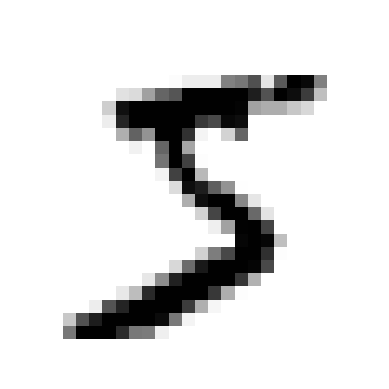

In [26]:
import matplotlib.pyplot as plt

def show_digit(some_digit: np.ndarray = X[0]):
    some_digit_image = some_digit.reshape(28,28)
    plt.imshow(some_digit_image, cmap="binary")
    plt.axis("off")
    plt.show()
    return

show_digit()

In [28]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

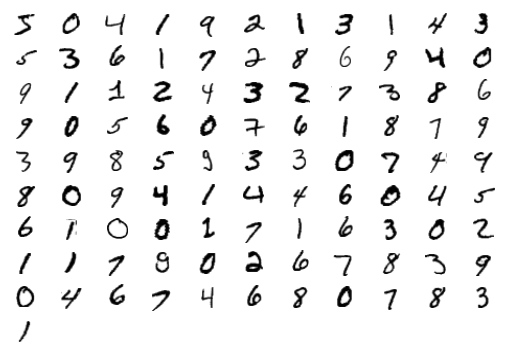

In [41]:
def show_digits(digits: np.ndarray = X[:100]):
    m: int = len(digits)
    edge: int = int(np.sqrt(m)) + 1
    for i in range(m):
        plt.subplot(edge,edge,i+1)
        plt.imshow(digits[i].reshape(28,28),cmap="binary")
        plt.axis("off")
    plt.show()
    return

some_digit: np.ndarray = X[0]
show_digits()


In [32]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [34]:
# 5-detector
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
#  Labels of True and False.

In [35]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [38]:
sgd_clf.predict([X_train[0]])

array([ True])

In [40]:
y_train_5[0]

True

# Performance Measures

## Measuring Acuracy Using Cross-Validation

In [45]:
# Do some DIY - Stratified CV (K-Fold Validation)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from typing import List
def strat_cv(clf, X: np.ndarray, y: np.ndarray, cv=3):
    """
    Scoring="Accuracy".
    """
    results: List[float] = []
    skfold = StratifiedKFold(n_splits=cv, random_state=42, shuffle=True)

    for train_index, test_index in skfold.split(X, y):
        clone_clf = clone(clf)
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_test_fold = X[test_index]
        y_test_fold = y[test_index]

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        results.append(n_correct / len(y_pred))
    return results

strat_cv(sgd_clf, X_train, y_train_5)

[0.9669, 0.91625, 0.96785]

In [46]:
# cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [49]:
# A Never5Classifier
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)

In [50]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [51]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [52]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
#  Each row: actual class;
#  each column: predicted class.

array([[53892,   687],
       [ 1891,  3530]])

In [55]:
# Perfect predictions
for y_train_perfect_predictions in (y_train_5,):
    print(confusion_matrix(y_train_5, y_train_perfect_predictions))

[[54579     0]
 [    0  5421]]


### Precision and Recall

In [57]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score
print('Precision:', precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))


Precision: 0.8370879772350012
Recall: 0.6511713705958311


In [58]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Tradeoff

In [2]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [3]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [4]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [16]:
import bisect

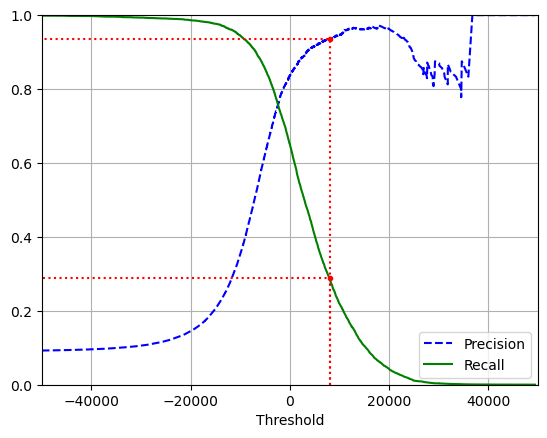

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold=8000):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    if threshold is not None:
        near_ix = bisect.bisect(thresholds, threshold)

        plt.plot([thresholds[near_ix],thresholds[near_ix], thresholds[0]], [0., precisions[near_ix], precisions[near_ix]], "r:")

        plt.plot([thresholds[near_ix],thresholds[near_ix], thresholds[0]], [0., recalls[near_ix], recalls[near_ix]], "r:")

        plt.plot([thresholds[near_ix]],[precisions[near_ix]], "r.")

        plt.plot([thresholds[near_ix]],[recalls[near_ix]], "r.")

    plt.xlabel("Threshold")
    plt.grid()
    plt.legend()
    return

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim(-50000,50000)
plt.ylim(0.,1.)
plt.show()

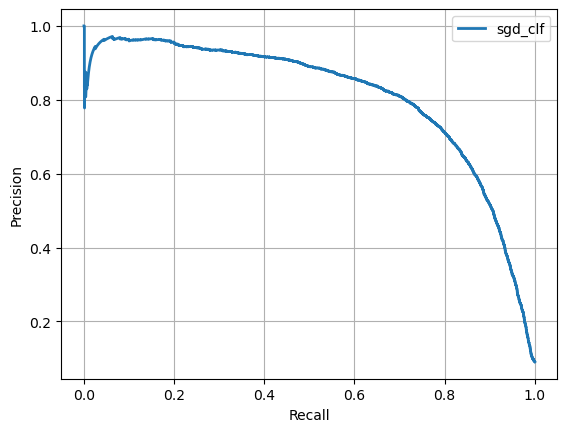

In [28]:
def plot_pr_curve(precisions, recalls, label=None):
    plt.plot(recalls, precisions, linewidth=2, label=label)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.grid(); plt.legend()
    return

plot_pr_curve(precisions, recalls, "sgd_clf")
plt.show()

In [18]:
# Aim for 90% precision
threshold_90_precision = thresholds[bisect.bisect(precisions, 0.90)]

In [19]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [20]:
precision_score(y_train_5, y_train_pred_90)

0.9002424662279183

In [21]:
recall_score(y_train_5, y_train_pred_90)

0.47943183914406934

### The ROC Curve

The receiver operating characteristic curve.

Denominator: actual positive or negative instances;

Numerator: predicted instances (true positive(TP) or false positive (FP)).

ROC: sensitivity (recall) vs 1-specificity(TNR, true negative rate)

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

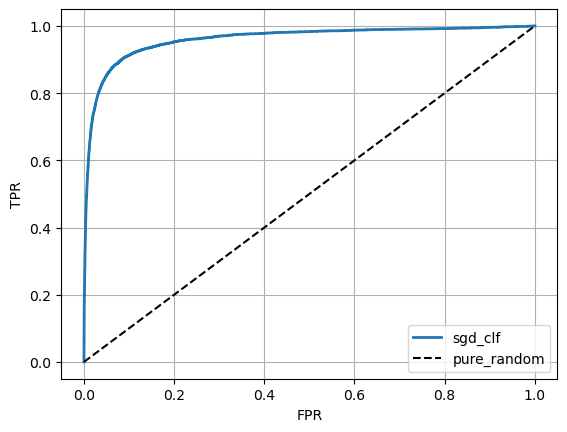

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label="pure_random") # Diagonal.
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.grid(); plt.legend()
    return

plot_roc_curve(fpr, tpr, "sgd_clf")
plt.show()

#### Measure ROC area-under-curve(AUC)

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.

In [29]:
# dill.dump_session("session.tmp")

In [1]:
# import dill
# dill.load_session("session.tmp")

RandomForestClassifier.

In [2]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [3]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

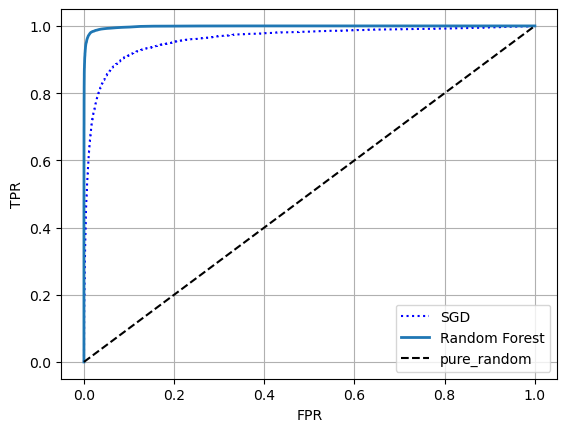

In [4]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [5]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass classification

## OvR or OvO

OvO: select the class that won the most duels.

In [7]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [8]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [9]:
# Force use OvO or OvR
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [10]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [11]:
len(ovr_clf.estimators_)

10

In [12]:
# Training SGDClf or RandomForestClf is easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [13]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [14]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [15]:
# Simply scaling the inputs increases accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [16]:
# import dill
# dill.dump_session("session.tmp")
import dill
dill.load_session("session.tmp")